## AR (Autoregression)

In [1]:
import pandas

In [2]:
df_train = pandas.read_csv('air-passengers-train.csv', index_col=[0])
display(df_train)

df_test = pandas.read_csv('air-passengers-test.csv', index_col=[0])
display(df_test)
print(df_test.shape)

,#Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121
...,...
1958-04,348
1958-05,363
1958-06,435


,#Passengers
Month,
1958-09,404
1958-10,359
1958-11,310
1958-12,337
1959-01,360
1959-02,342
1959-03,406
1959-04,396
1959-05,420


(28, 1)


In [3]:
import pandas
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier

class simple_autoregression:
    def __init__(self, window_size, model = LinearRegression):
        self.window_size = window_size
        self.model = model()
        self.lagged_df = None
        
    def train(self, df):
        ws = self.window_size
        # there will be 'window_size' rows to be dropped
        # the shape will be row(df)-window_size : col(df)
        #
        # At least "window_size" rows are required 
        # to be enough to be transformed into a lagged row for forecasting
        #if len(df) - ws < ws:
        #    raise ValueError('the size of the dataset is not enough for forecasting')
        
        # generates lagged dataframe
        lagged_df = []
        for s in range(ws, -1, -1):
            lagged_df.append(df.shift(s))
        lagged_df = pandas.concat(lagged_df, axis=1)

        # fill in the column names
        X_columns = []
        for s in range(ws, 0, -1):
            X_columns.append('shift-' + str(s))
        y_column = ['target']
        lagged_df.columns = X_columns + y_column

        # drop na rows (the first `shift_size` rows)
        lagged_df.dropna(inplace = True)
        
        self.model.fit(lagged_df[X_columns], lagged_df[y_column])
        self.lagged_df = lagged_df
        return self
    
    def predict(self, next_steps=1):
        rows, cols = self.lagged_df.shape
        future_df = pandas.DataFrame(columns=self.lagged_df.columns)

        # predict the first step
        X = self.lagged_df['target'][rows - cols + 1 : rows + 1].to_list()
        y = [self.model.predict([X]).ravel()[0]]
        future_df.loc[0] = X + y
        
        # predict the remaining steps
        for step in range(next_steps - 1):
            X = future_df.loc[step][1:].to_list()
            y = [self.model.predict([X]).ravel()[0]]
            future_df.loc[step+1] = X + y
        return future_df

    def get_fitted_target(self):
        '''
        get the y_train (used to measure the performance of the model)
        '''
        if self.lagged_df is None:
            raise Exception('Please call the train() API first.')
        
        feature_columns = list(self.lagged_df.columns)
        feature_columns.remove('target')
        fitted_target = self.model.predict(self.lagged_df[feature_columns])
        fitted_target = fitted_target.ravel()
        return fitted_target

In [4]:
import matplotlib.pyplot as plt
    
def plot_result(df_train, df_test, df_pred):
    plt.figure(figsize=(12,5), dpi=100)

    # training part
    plt.plot(df_train[['#Passengers']], color='tab:blue', label='train')

    # separating line
    plt.plot([df_train.index[-1], df_train.index[-1]],
            [min(df_test[df_train.columns[0]]), max(df_test[df_train.columns[0]])],
            color='black', linewidth=1)

    # testing part
    x = [df_train.index[-1]]
    x.extend(df_test.index)
    y = [df_train['#Passengers'].to_numpy()[-1]]
    y.extend(df_test['#Passengers'].to_numpy())
    plt.plot(x, y, color='tab:blue', linestyle='dashed', label='test')

    # predicting part
    x = [df_train.index[-1]]
    x.extend(df_pred.index)
    y = [df_train['#Passengers'].to_numpy()[-1]]
    y.extend(df_pred['#Passengers'].to_numpy())
    plt.plot(x, y, color='tab:orange', linestyle='dashed', label='predict (by AR)')

    plt.xticks([str(y) + '-01' for y in range(1949, 1962)])
    plt.legend()
    plt.grid()
    plt.show()

train:
 - R2: 0.983623
 - MSE: 132.28624
 - RMSE: 11.501576
predict:
 - R2: 0.721621
 - MSE: 1716.964243
 - RMSE: 41.436267


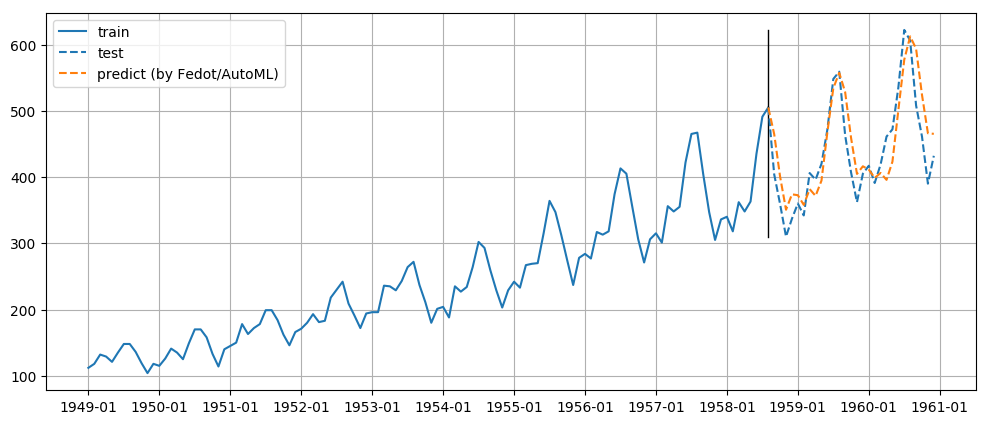

In [5]:
from sklearn.metrics import r2_score, mean_squared_error

window_size = 12
ar_model = simple_autoregression(window_size)
ar_model.train(df_train)

y_train = ar_model.get_fitted_target()
y_true = df_train.iloc[-len(y_train):, 0]
print('train:')
print(' - R2:', round(r2_score(y_true, y_train), 6))
print(' - MSE:', round(mean_squared_error(y_true, y_train, squared=True), 6))
print(' - RMSE:', round(mean_squared_error(y_true, y_train, squared=False), 6))

y_pred = ar_model.predict(next_steps=len(df_test))
y_pred = y_pred['target']
y_true = df_test.iloc[:, 0]
print('predict:')
print(' - R2:', round(r2_score(y_true, y_pred), 6))
print(' - MSE:', round(mean_squared_error(y_true, y_pred, squared=True), 6))
print(' - RMSE:', round(mean_squared_error(y_true, y_pred, squared=False), 6))

df_pred = pandas.DataFrame(
    y_pred.to_numpy(), index=df_test.index, columns=['#Passengers'])

plot_result(df_train, df_test, df_pred)

train:
 - R2: 0.991599
 - MSE: 59.709252
 - RMSE: 7.727176
predict:
 - R2: 0.923179
 - MSE: 473.812994
 - RMSE: 21.767246


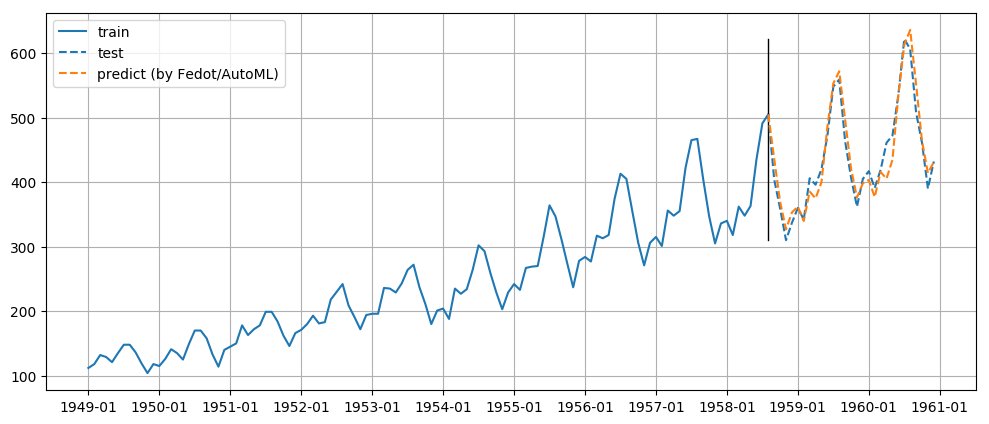

In [6]:
from sklearn.metrics import r2_score, mean_squared_error

window_size = 24
ar_model = simple_autoregression(window_size)
ar_model.train(df_train)

y_train = ar_model.get_fitted_target()
y_true = df_train.iloc[-len(y_train):, 0]
print('train:')
print(' - R2:', round(r2_score(y_true, y_train), 6))
print(' - MSE:', round(mean_squared_error(y_true, y_train, squared=True), 6))
print(' - RMSE:', round(mean_squared_error(y_true, y_train, squared=False), 6))

y_pred = ar_model.predict(next_steps=len(df_test))
y_pred = y_pred['target']
y_true = df_test.iloc[:, 0]
print('predict:')
print(' - R2:', round(r2_score(y_true, y_pred), 6))
print(' - MSE:', round(mean_squared_error(y_true, y_pred, squared=True), 6))
print(' - RMSE:', round(mean_squared_error(y_true, y_pred, squared=False), 6))

df_pred = pandas.DataFrame(
    y_pred.to_numpy(), index=df_test.index, columns=['#Passengers'])

plot_result(df_train, df_test, df_pred)

## Scan the window sizes
> the best window size is 29 (24 + 5)

In [7]:
from sklearn.metrics import r2_score, mean_squared_error

df_metrics = pandas.DataFrame(columns=['window-size', 'train-r2', 'train-rmse', 'test-r2', 'test-rmse'])
metrics = None

# search the best window sisize
for window_size in range(2, len(df_train)):
    if len(df_train) - window_size < window_size:
        # the size of the dataset is not enough for forecasting
        break
    
    ar_model = simple_autoregression(window_size)
    ar_model.train(df_train)

    metrics = [window_size]
    
    # training info
    y_train = ar_model.get_fitted_target()
    # if len(y_true)=116 and window_size = 12:
    #    len(y_train) will be 116-12=104
    y_true = df_train.iloc[-len(y_train):, 0] # -104:-1 = 12:116
    score = r2_score(y_true, y_train)
    metrics.append(score)
    score = mean_squared_error(y_true, y_train, squared=False)
    metrics.append(score)

    # prediction info
    y_pred = ar_model.predict(next_steps=len(df_test)).target
    y_true = df_test.iloc[:, 0]
    score = r2_score(y_true, y_pred)
    metrics.append(score)
    score = mean_squared_error(y_true, y_pred, squared=False)
    metrics.append(score)
    
    df_metrics.loc[len(df_metrics)] = metrics
    
display(df_metrics)

,window-size,train-r2,train-rmse,test-r2,test-rmse
0,2.0,0.925194,2.546152e+01,-1.102333,113.870941
1,3.0,0.927029,2.509454e+01,-0.382980,92.357060
2,4.0,0.926168,2.517620e+01,-0.366849,91.816851
3,5.0,0.931734,2.411554e+01,-0.117443,83.018478
4,6.0,0.931257,2.414433e+01,-0.134285,83.641783
5,7.0,0.931297,2.411447e+01,-0.050190,80.481482
6,8.0,0.933697,2.366425e+01,0.044649,76.761520
7,9.0,0.949581,2.058123e+01,0.392118,61.231040
8,10.0,0.951964,1.998314e+01,0.535062,53.550028
9,11.0,0.978903,1.313610e+01,0.714275,41.979397
